# Driver Fatigue Detection Using CNN-LSTM Fusion Model
###  Driver drowsiness is one of the world’s major causes for accidents on roads, further calling for the urgent need to use effective real-time monitoring solutions. Most drowsiness detectors had traditionally used facial-tracking techniques to detect visible signs that suggest fatigue, such as drooping eyelids or slow blinks.


---


## Types of subjects in dataset:
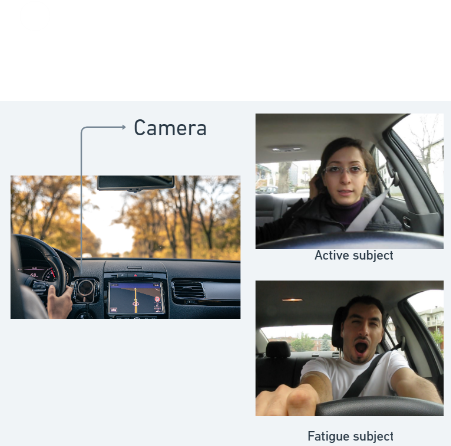
### The model architecture uses a hybrid design that combined CNN and LSTM networks for classification into two categories:
 - Fatigue Subjects
 - Active Subjects.
 ### This architecture leverages the strengths of both CNN and LSTM for achieving accurate and robust classification, particularly suited for sequential image data or video streams
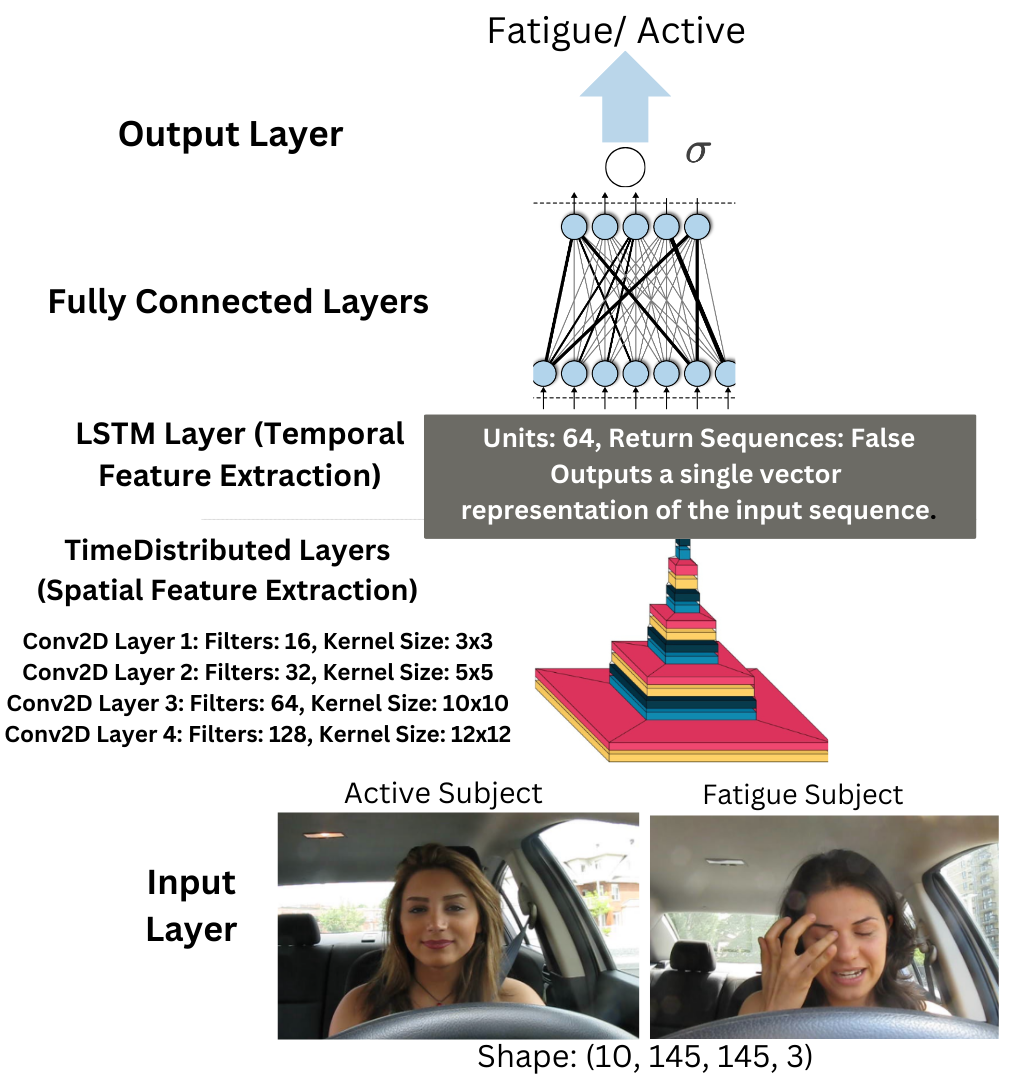

## Import libraries

In [ ]:
!pip install mediapipe
import pandas as pd
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 31.6 MB/s eta 0:00:00


# Download dataset

In [ ]:
!kaggle datasets download -d rakibuleceruet/drowsiness-prediction-dataset
!kaggle datasets download -d adinishad/prediction-images

Dataset URL: https://www.kaggle.com/datasets/rakibuleceruet/drowsiness-prediction-dataset
License(s): unknown
100% 2.17G/2.17G [01:48<00:00, 22.1MB/s]
100% 2.17G/2.17G [01:48<00:00, 21.4MB/s]
Dataset URL: https://www.kaggle.com/datasets/adinishad/prediction-images
License(s): unknown
 85% 1.00M/1.18M [00:00<00:00, 1.09MB/s]
100% 1.18M/1.18M [00:00<00:00, 1.24MB/s]


# Unzip dataset

In [ ]:
!unzip drowsiness-prediction-dataset.zip
!unzip prediction-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: 0 FaceImages/Active Subjects/img_k_12330.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12360.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12390.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12420.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12450.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12480.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12510.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12540.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12570.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12600.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12630.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12660.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12690.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12720.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12750.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_1

In [ ]:
os.makedirs('./Fatigue Subjects')
os.makedirs('./Active Subjects')

Image preprocessing

In [ ]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs))

# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))

# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)

# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [ ]:
IMG_SIZE=145
i=0
def draw(
    *,n=i,
    img_dt,cat,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt

    # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks

    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen

    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness,
        circle_radius=ts_circle_radius,
        color=(255, 255, 255)
    )


    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )
    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark

    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.

    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(image_eye_lmks,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

    if cat=='Fatigue Subjects':
        cv2.imwrite(str('./Fatigue Subjects/'+str(n)+'.jpg'), image_drawing_tool)
    else:
        cv2.imwrite(str('./Active Subjects/'+str(n)+'.jpg'), image_drawing_tool)

    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE))
    return resized_array

In [ ]:
imgH, imgW, _=0,0,0
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

     # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        # If detections are available.
        if results.multi_face_landmarks:
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                resized_array= draw(img_dt=image.copy(), cat=category, n=i,face_landmarks=face_landmarks)
    return resized_array

In [ ]:
def face_for_yawn(direc="/content/0 FaceImages", face_cas_path="/content/haarcascade_frontalface_default.xml"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                land_face_array=landmarks(roi_color,category,i)
                yaw_no.append([land_face_array, class_num1])
                i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


In [ ]:
dir_path = r'./Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
3869


In [ ]:
dir_path = r'./Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Fatigue images :
3669


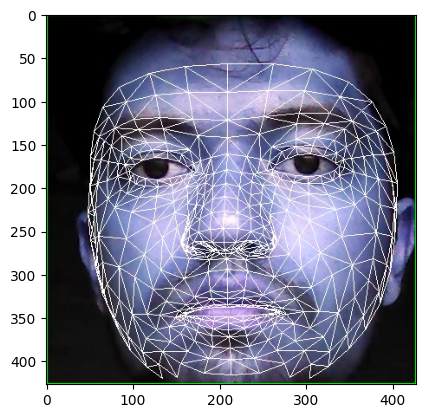

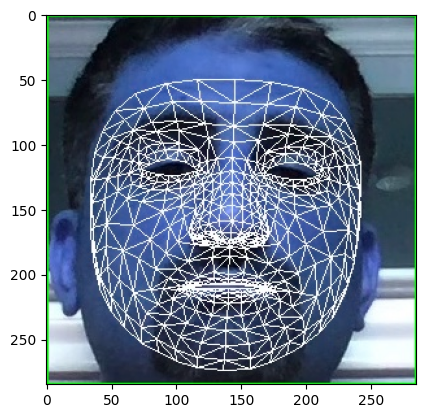

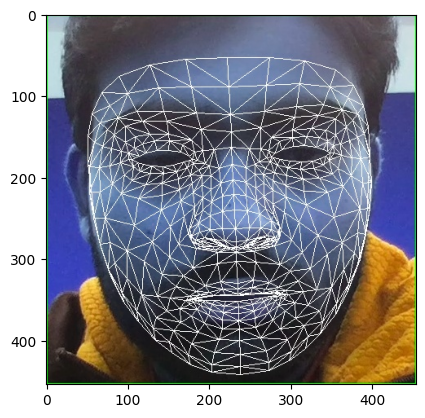

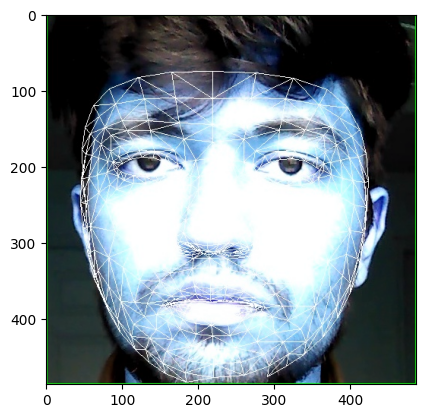

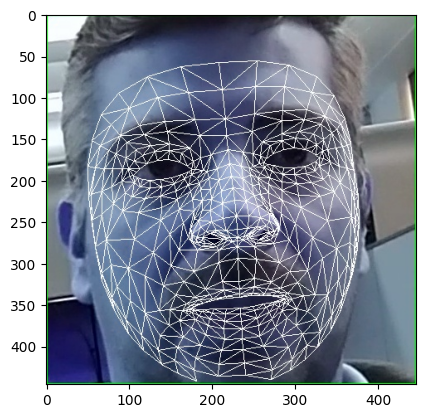

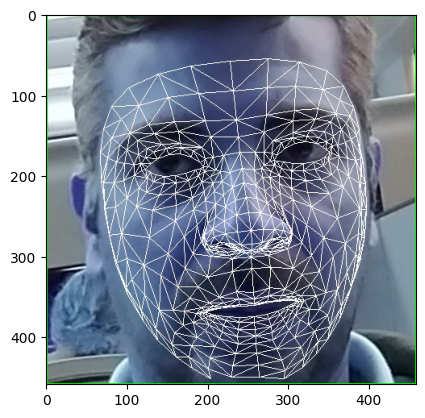

In [ ]:
categories = ["Fatigue Subjects", "Active Subjects"]
for category in categories:
  for idx, img in enumerate(os.listdir(f'./{category}')):
      if idx > 5:
        break
      img_file = cv2.imread(f'./{category}/{img}')
      plt.imshow(img_file)
      plt.show()
      plt.close()

Resizing Images

In [ ]:
import os
import time
def face_for_yawn(direc="./"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            yaw_no.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


Seperate label and features

In [ ]:
X = []
y = []
for feature, label in yawn_no_yawn:
    X.append(feature)
    y.append(label)

Reshape the array

In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

Label encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

Splitting

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
len(X_test)

1508

In [ ]:
len(X_train)

6030

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Data Augmentation

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

## Model

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, Flatten
)
from tensorflow.keras.optimizers import Adam

# Define the MobileNet as the base model
base_model = MobileNet(
    weights='imagenet',  # Use pre-trained weights
    include_top=False,   # Exclude fully connected layers
    input_shape=(145, 145, 3)
)

# Freeze the base model layers to use them as feature extractors
base_model.trainable = False

# Build the custom model on top of MobileNet
model_input = Input(shape=(145, 145, 3))
x = base_model(model_input)
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=model_input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


<ipython-input-31-44cda34c49c2>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 145, 145, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,369,153 (12.85 MB)

 Trainable params: 139,905 (546.50 KB)

 Non-trainable params: 3,229,248 (12.32 MB)

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Dropout, LSTM, Reshape, BatchNormalization
)
from tensorflow.keras.optimizers import Adam

# Define the MobileNet as the base model
base_model = MobileNet(
    weights='imagenet',  # Use pre-trained weights
    include_top=False,   # Exclude fully connected layers
    input_shape=(224, 224, 3)  # Set to default MobileNet input size
)

# Freeze the base model layers to use them as feature extractors
base_model.trainable = False

# Add new layers for our specific task
model_input = Input(shape=(224, 224, 3))  # Match input shape of MobileNet
x = base_model(model_input)

# Global average pooling layer
x = GlobalAveragePooling2D()(x)  # Output: (batch_size, features)

# Add LSTM-compatible reshaping
x = Reshape((1, -1))(x)  # Reshape to (batch_size, time_steps, features)

# Add LSTM for sequence processing
x = LSTM(64, return_sequences=False)(x)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=model_input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 1, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │         278,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,524,801 (13.45 MB)

 Trainable params: 295,681 (1.13 MB)

 Non-trainable params: 3,229,120 (12.32 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=70,
    validation_data=test_generator
)

# Save the trained model
model.save('mobileNet_finetuned_model.h5')


Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 52s 219ms/step - accuracy: 0.5919 - loss: 0.8009 - val_accuracy: 0.7520 - val_loss: 0.4707
Epoch 2/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 67s 168ms/step - accuracy: 0.7085 - loss: 0.5998 - val_accuracy: 0.7944 - val_loss: 0.4101
Epoch 3/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.7386 - loss: 0.5481 - val_accuracy: 0.8011 - val_loss: 0.4067
Epoch 4/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 168ms/step - accuracy: 0.7559 - loss: 0.5188 - val_accuracy: 0.8103 - val_loss: 0.3882
Epoch 5/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.7553 - loss: 0.5031 - val_accuracy: 0.8156 - val_loss: 0.3727
Epoch 6/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - accuracy: 0.7777 - loss: 0.4695 - val_accuracy: 0.8422 - val_loss: 0.3486
Epoch 7/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - accuracy: 0.7656 - loss: 0.4770 - val_accuracy: 0.8389 - val_loss: 0.3509
Epoch 8/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.7834 - loss: 0.4719 - val

In [ ]:

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9024 - loss: 0.2803
Test Loss: 0.282631516456604
Test Accuracy: 0.8912466764450073


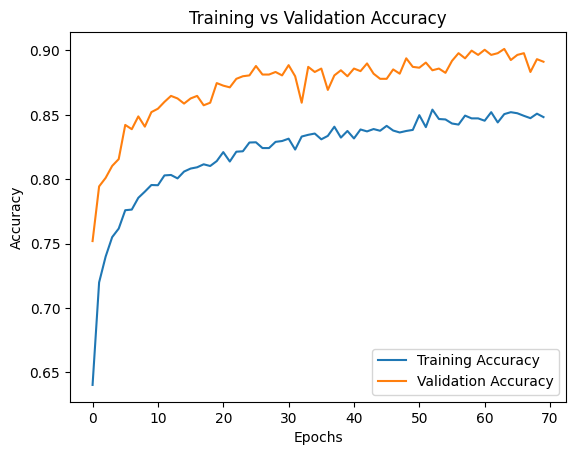

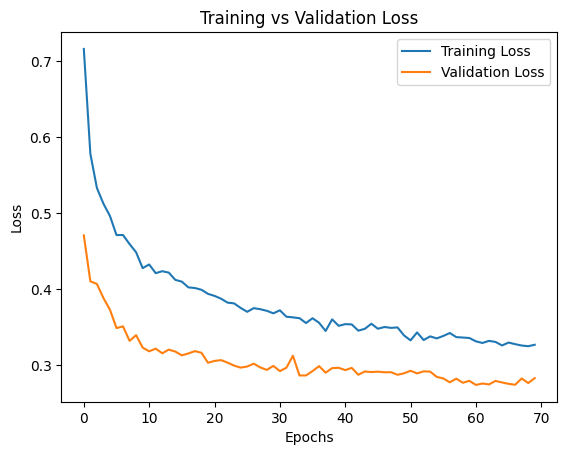

In [ ]:
# Optionally, plot training and validation accuracy/loss
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# You can evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9024 - loss: 0.2803


{'loss': 0.282631516456604, 'compile_metrics': 0.8912466764450073}

In [ ]:
from tensorflow.keras.applications import MobileNetV2 # Importing MobileNetV2 class
from tensorflow.keras.layers import Dense, Flatten # Importing Dense, Flatten layers for layer definition
from tensorflow.keras.models import Model  # Importing Model class for model definition
import keras
from tensorflow.keras.optimizers import Adam  # Importing Adam optimizer for model compilation
# Rest of the code remains unchanged

In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(145, 145, 3),
)
type(base_model)
base_model.summary()
model=keras.Sequential()
for layer in base_model.layers[:-25] :
    layer.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

model.compile(optimizer=Adam(0.0001 ), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
   train_batches,
    epochs=10,
    validation_data=val_batches,
    batch_size=32
)

<ipython-input-47-85e6b503dd7c>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 145, 145, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 73, 73, 32)     │            864 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 73, 73, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 73, 73, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 73, 73, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 73, 73, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 73, 73, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 73, 73, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 73, 73, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 73, 73, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 73, 73, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 73, 73, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 75, 75, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 37, 37, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 145, 145, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 73, 73, 32)     │            864 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 73, 73, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 73, 73, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 73, 73, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 73, 73, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 73, 73, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 73, 73, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 73, 73, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 73, 73, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 73, 73, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 73, 73, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 75, 75, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 37, 37, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 35,552,834 (135.62 MB)

 Trainable params: 34,656,770 (132.21 MB)

 Non-trainable params: 896,064 (3.42 MB)

NameError: name 'train_batches' is not defined

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

# Generate predictions on the test set
y_pred = model.predict(test_generator, verbose=1)

# Convert predictions to binary values
y_pred = np.round(y_pred)

# Get all batches from the test generator
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)

# Convert the list of labels to a NumPy array
y_true = np.array(y_true)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

# Print the classification report
print("Classification Report:")
print(report)

# Calculate precision, recall, and F1 score individually (for binary classification)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print precision, recall, and F1 score
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



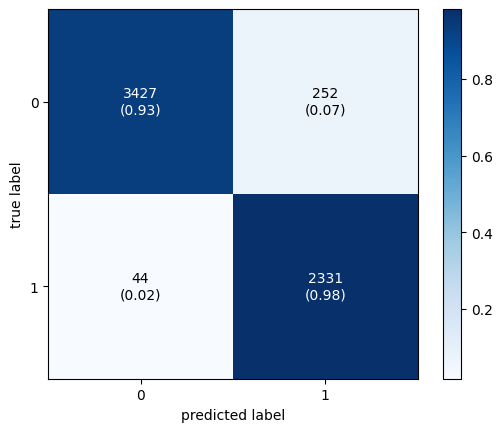

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
binary1 = np.array([[3427,252],[44,2331]])
fig, ax = plot_confusion_matrix(conf_mat=binary1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence

# Define the sequence length
sequence_length = 10

# --- Data Preparation ---
# Reshape data for TimeDistributed layers
def reshape_data(data, labels, sequence_length):
    """Reshapes data and labels to create sequences for TimeDistributed layers."""
    num_sequences = data.shape[0] // sequence_length
    data_sequences = data[:num_sequences * sequence_length].reshape(num_sequences, sequence_length, 145, 145, 3)
    # Reshape labels to match the number of sequences
    labels_sequences = labels[:num_sequences * sequence_length].reshape(num_sequences, sequence_length)
    # Take the last label of each sequence
    labels_sequences = labels_sequences[:, -1]
    return data_sequences, labels_sequences

class TimeDistributedImageDataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size, image_data_generator):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.image_data_generator = image_data_generator

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Apply augmentations to each image in the sequence
        for i in range(batch_x.shape[0]):
            for j in range(batch_x.shape[1]):
                batch_x[i, j] = self.image_data_generator.random_transform(batch_x[i, j])

        return batch_x, batch_y

# --- Data Augmentation and Generators ---
train_datagen = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_datagen = ImageDataGenerator(rescale=1/255)

# Create custom generators
train_generator = TimeDistributedImageDataGenerator(X_train_sequences, y_train_sequences, batch_size=32, image_data_generator=train_datagen)
test_generator = TimeDistributedImageDataGenerator(X_test_sequences, y_test_sequences, batch_size=32, image_data_generator=test_datagen)



# Define the model
model = Sequential()

# Add the CNN layers with Batch Normalization and Dropout
model.add(TimeDistributed(Conv2D(16, 3, activation='relu', padding='same'), input_shape=(sequence_length, 145, 145, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D()))
model.add(TimeDistributed(Dropout(0.1)))

model.add(TimeDistributed(Conv2D(32, 5, activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D()))
model.add(TimeDistributed(Dropout(0.1)))

model.add(TimeDistributed(Conv2D(64, 10, activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D()))
model.add(TimeDistributed(Dropout(0.1)))

model.add(TimeDistributed(Conv2D(128, 12, activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Flatten()))

# Add the LSTM layer to process the sequence of CNN outputs
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.25))

# Add Dense layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

# Display the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 143, 143, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 143, 143, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 67, 67, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 67, 67, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 33, 33, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 1, 128)           │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 1, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,423,713 (5.43 MB)

 Trainable params: 1,423,233 (5.43 MB)

 Non-trainable params: 480 (1.88 KB)

## Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set up callbacks
callbacks = [
    ModelCheckpoint(
        filepath='best_model.keras',  # Save the best model during training
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,  # Stop training if no improvement for 10 epochs
        restore_best_weights=True
    )
]

# Train the model
history = model.fit(
    train_generator,
    epochs=70,
    validation_data=test_generator,
    callbacks=callbacks,
    verbose=1  # Display progress during training
)


Epoch 1/70


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 145, 145, 3)

## Testing

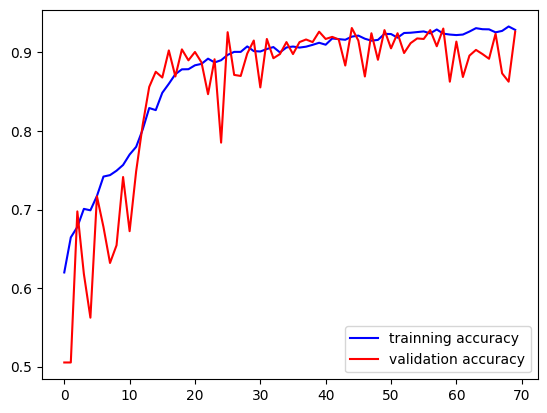

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
# You can evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9276 - loss: 0.1752


{'loss': 0.17190252244472504, 'compile_metrics': 0.9263925552368164}

## Saving the model

In [ ]:
model.save('my_model.h5')
#model = tf.keras.models.load_model('my_model.h5')

Testing the model

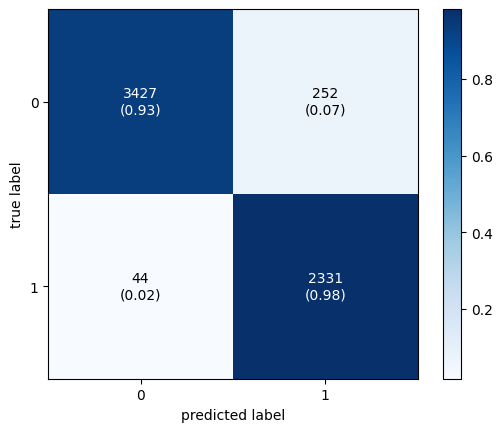

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
binary1 = np.array([[3427,252],[44,2331]])
fig, ax = plot_confusion_matrix(conf_mat=binary1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

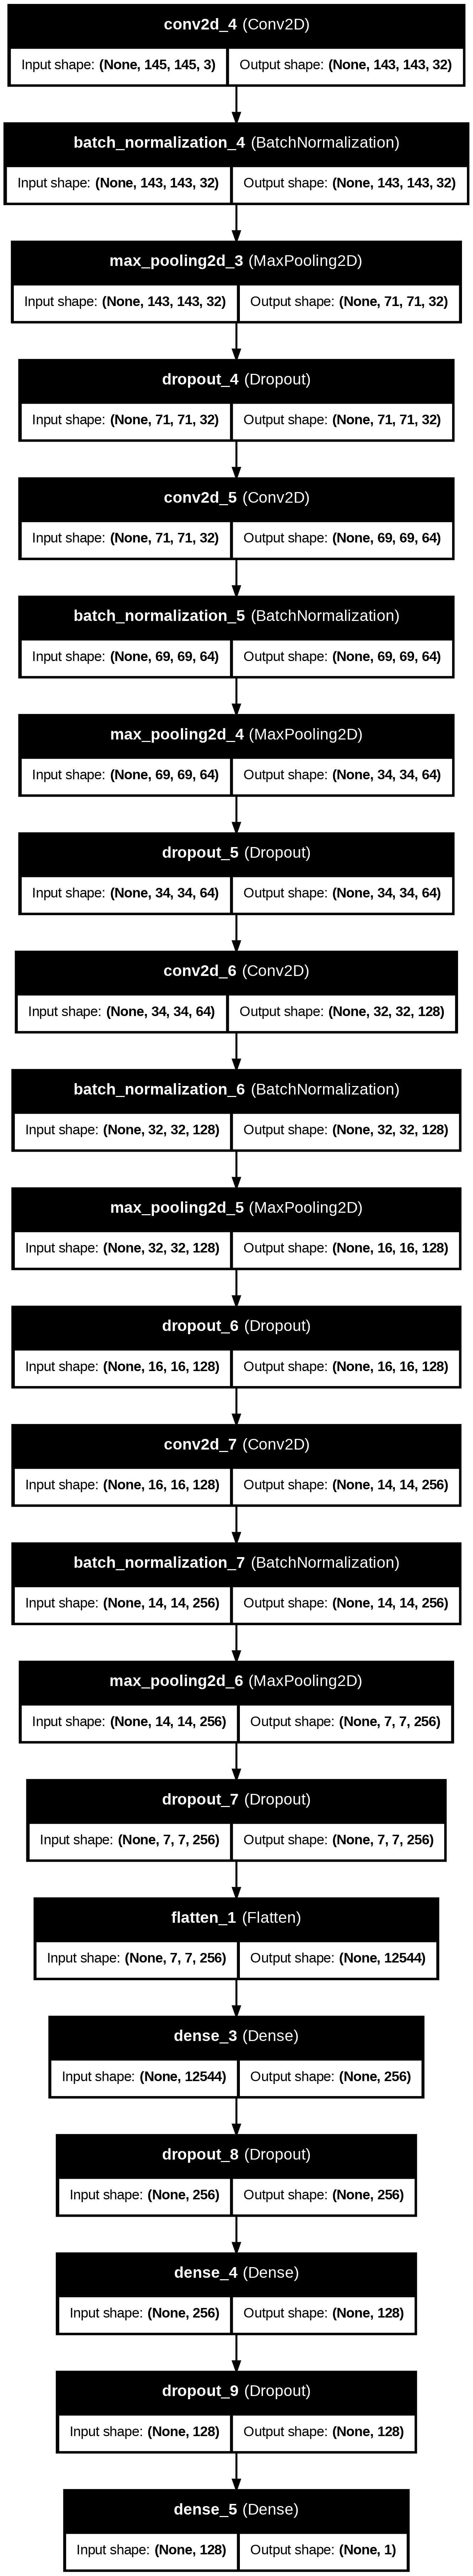

In [ ]:
# Instead of using keras.utils.vis_utils, use tensorflow.keras.utils:
from tensorflow.keras.utils import plot_model

# The rest of your code should work as expected:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 50.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


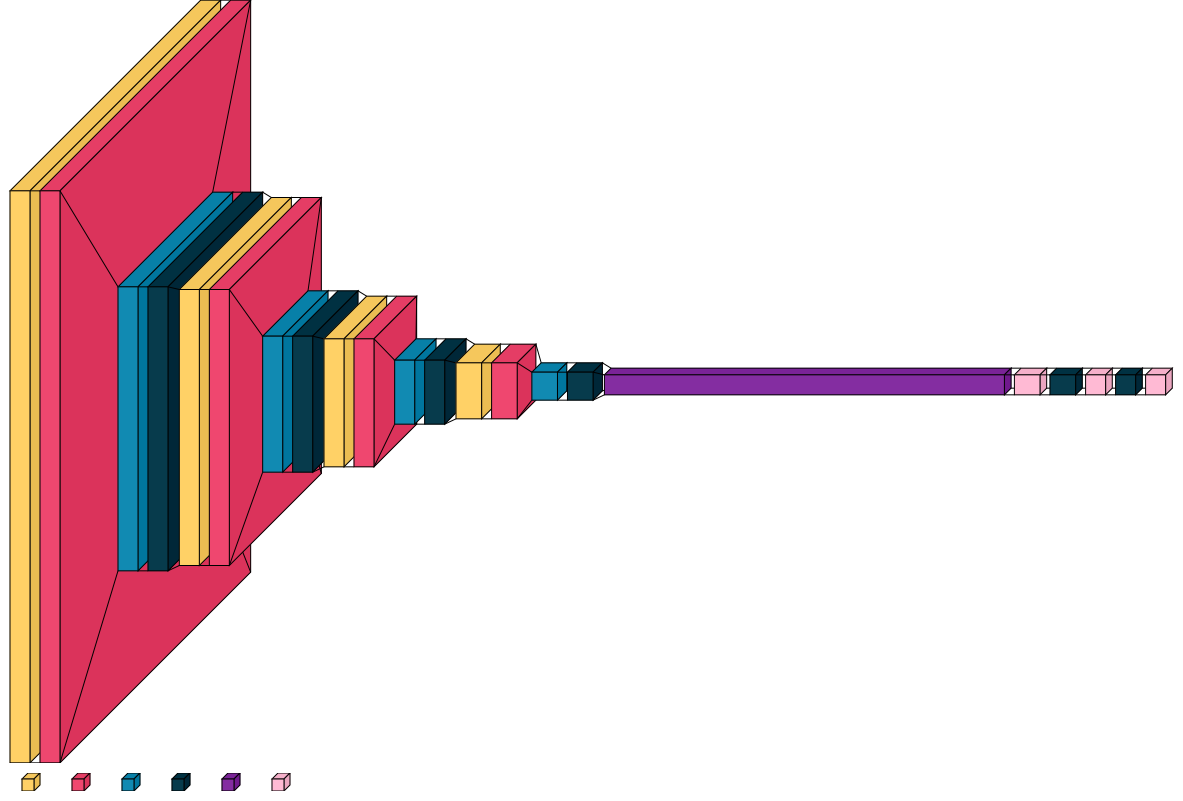

In [ ]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model,legend=True)

In [ ]:
!pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii
keras2ascii(model)

  Preparing metadata (setup.py) ... done
  Created wheel for keras_sequential_ascii: filename=keras_sequential_ascii-0.1.1-py3-none-any.whl size=3048 sha256=d9f97996081f7ea5a6f3f62e0c5e2e648a8f60c9957448464b9183ffc1d4a7ad
  Stored in directory: /root/.cache/pip/wheels/50/10/f3/5eeae758ef81ee4e16d618471561509355b0f2e5f38bf41185
Successfully built keras_sequential_ascii


AttributeError: 'Conv2D' object has no attribute 'input_shape'

#TEST THE MODEL ON IMAGES FROM WEB

In [ ]:
import cv2
import numpy as np
from tensorflow import keras
import urllib.request
import matplotlib.pyplot as plt

In [ ]:
model = keras.models.load_model('my_model.h5')

In [ ]:
IMG_SIZE = 145
image_url = 'https://thumbs.dreamstime.com/b/tired-man-car-sleepy-drowsy-driver-fatigue-driving-sleeping-vehicle-exhausted-bored-drunk-person-serious-upset-331634548.jpg?w=768'
req = urllib.request.urlopen(image_url)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image = cv2.imdecode(arr, -1)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
image = image / 255.0
image = np.expand_dims(image, axis=0)

In [ ]:
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


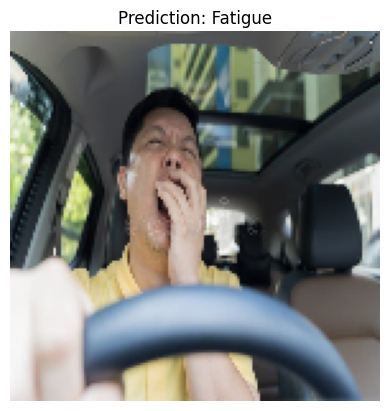

In [ ]:
plt.imshow(cv2.cvtColor(cv2.resize(cv2.imdecode(arr, -1), (IMG_SIZE, IMG_SIZE)), cv2.COLOR_BGR2RGB))
plt.title(f'Prediction: {"Fatigue" if prediction[0][0] < 0.5 else "Active"}')
plt.axis('off')
plt.show()

In [ ]:
IMG_SIZE = 145
image_url = 'https://photos.peopleimages.com/picture/202310/2955857-fitness-city-portrait-and-woman-exercise-determined-and-ready-for-outdoor-cardio-workout-commitment-or-sports.-sweaty-face-road-and-active-athlete-runner-or-person-for-street-training-challenge-zoom_90.jpg'
req = urllib.request.urlopen(image_url)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image = cv2.imdecode(arr, -1)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
image = image / 255.0
image = np.expand_dims(image, axis=0)

In [ ]:
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


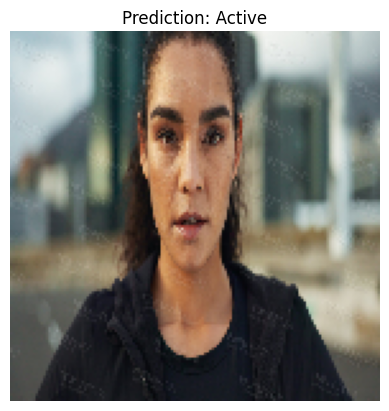

In [ ]:
plt.imshow(cv2.cvtColor(cv2.resize(cv2.imdecode(arr, -1), (IMG_SIZE, IMG_SIZE)), cv2.COLOR_BGR2RGB))
plt.title(f'Prediction: {"Fatigue" if prediction[0][0] < 0.5 else "Active"}')
plt.axis('off')
plt.show()